# Example 3. TorchSKInterface (Still under development)

Notebook with an example of a gojo.core.base.TorchSKInterface

In [1]:
import sys

sys.path.append('..')

import torch
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

# GOJO libraries
from gojo import core
from gojo import deepl
from gojo import util
from gojo import plotting

DEVICE = 'mps'

In [2]:
# load test dataset (Wine)
wine_dt = datasets.load_wine()

# create the target variable. Classification problem 0 vs rest
# to see the target names you can use wine_dt['target_names']
y = (wine_dt['target'] == 1).astype(int)  
X = wine_dt['data']

# standardize input data
std_X = util.zscoresScaling(X)

# split Xs and Ys in training and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    std_X, y, train_size=0.8, random_state=1997, shuffle=True,
    stratify=y
)
X_train.shape, X_valid.shape, '%.3f' % y_train.mean(),  '%.3f' % y_valid.mean()

((142, 13), (36, 13), '0.401', '0.389')

In [3]:
model = core.TorchSKInterface(
    model=deepl.ffn.createSimpleFFNModel(
        in_feats=X_train.shape[1],
        out_feats=1,
        layer_dims=[20],
        layer_activation=torch.nn.ELU(),
        output_activation=torch.nn.Sigmoid()),
    iter_fn=deepl.iterSupervisedEpoch,
    loss_function=torch.nn.BCELoss(),
    n_epochs=50,
    train_split=0.8,
    train_split_stratify=True,
    optimizer_class=torch.optim.Adam,
    dataset_class=deepl.loading.TorchDataset,
    dataloader_class=torch.utils.data.DataLoader,
    optimizer_kw=dict(
        lr=0.001
    ),
    train_dataset_kw=None,
    valid_dataset_kw=None,
    train_dataloader_kw=dict(
        batch_size=16,
        shuffle=True
    ),
    valid_dataloader_kw=dict(
        batch_size=X_train.shape[0]
    ),
    iter_fn_kw= None,
    callbacks= None,
    seed=1997,
    device=DEVICE,
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5),
    verbose=1
)

In [4]:
model.train(X_train, y_train)

Training model...: 100%|████████████████████████████████████████████| 50/50 [00:06<00:00,  7.87it/s]


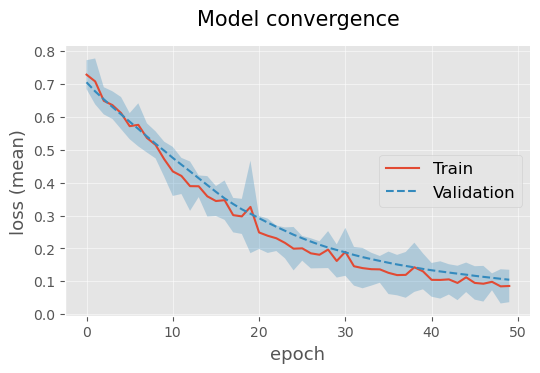

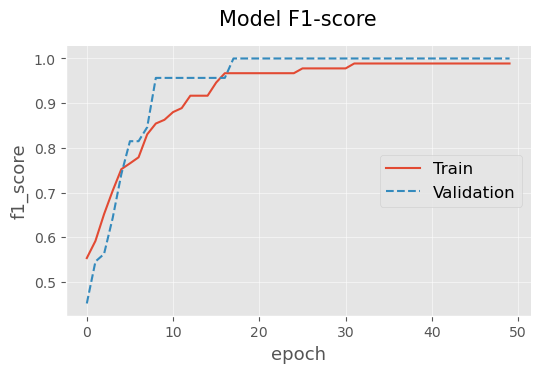

In [5]:
model_history = model.fitting_history

# display model convergence
plotting.linePlot(
    model_history['train'], model_history['valid'],
    x='epoch', y='loss (mean)', err='loss (std)',
    labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    legend_pos='center right')

# display model performance
plotting.linePlot(
    model_history['train'], model_history['valid'],
    x='epoch', y='f1_score', 
    labels=['Train', 'Validation'],
    title='Model F1-score',
    ls=['solid', 'dashed'],
    legend_pos='center right')

In [6]:
# test the model on the validation dataset
y_hat = model.performInference(X_valid)
pd.DataFrame([core.getScores(y_true=y_valid, y_pred=y_hat, 
               metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5))]).T.round(decimals=3)

,0
accuracy,1.0
balanced_accuracy,1.0
precision,1.0
recall,1.0
sensitivity,1.0
specificity,1.0
negative_predictive_value,1.0
f1_score,1.0
auc,1.0


In [7]:
# reset the model and perform the predictions
model.resetFit()
y_hat = model.performInference(X_valid)
core.getScores(y_true=y_valid, y_pred=y_hat, 
               metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5))

{'accuracy': 0.4444444444444444,
 'balanced_accuracy': 0.5194805194805194,
 'precision': 0.4,
 'recall': 0.8571428571428571,
 'sensitivity': 0.8571428571428571,
 'specificity': 0.18181818181818182,
 'negative_predictive_value': 0.6666666666666666,
 'f1_score': 0.5454545454545455,
 'auc': 0.5194805194805194}

In [8]:
# retrain the model and perform the predictions
model.train(X_train, y_train)
y_hat = model.performInference(X_valid)
core.getScores(y_true=y_valid, y_pred=y_hat, 
               metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5))

Training model...: 100%|████████████████████████████████████████████| 50/50 [00:04<00:00, 11.17it/s]


{'accuracy': 1.0,
 'balanced_accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'sensitivity': 1.0,
 'specificity': 1.0,
 'negative_predictive_value': 1.0,
 'f1_score': 1.0,
 'auc': 1.0}

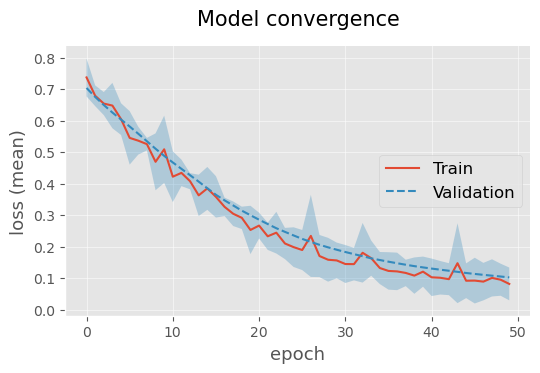

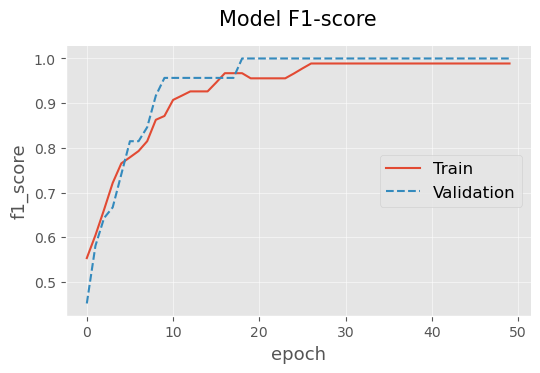

In [9]:
model_history = model.fitting_history

# display model convergence
plotting.linePlot(
    model_history['train'], model_history['valid'],
    x='epoch', y='loss (mean)', err='loss (std)',
    labels=['Train', 'Validation'],
    title='Model convergence',
    ls=['solid', 'dashed'],
    legend_pos='center right')

# display model performance
plotting.linePlot(
    model_history['train'], model_history['valid'],
    x='epoch', y='f1_score', 
    labels=['Train', 'Validation'],
    title='Model F1-score',
    ls=['solid', 'dashed'],
    legend_pos='center right')